In [3]:
from curses.ascii import isspace

%load_ext autoreload
%autoreload 2


import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import keras
import numpy as np
from graph import *
from encoder import create_encoder
import pandas as pd

from data_processing import processer
from semantic_clustering import *

from RepresentationLearner import RepresentationLearner
from compute import *
from GNN import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from IPython.display import display, HTML
display(HTML('''
    <script>
        var code = `
            IPython.OutputArea.prototype._should_scroll = function(lines) {
                return false;
            }
        `;
        $('head').append('<script>' + code + '</script>');
    </script>
'''))

import IPython
IPython.get_ipython().config.update({
    'ServerApp.iopub_data_rate_limit': 10000000,
    'ServerApp.rate_limit_window': 60.0
})


In [4]:


num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [5]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [6]:
x_data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [7]:
target_size = 32
representation_dims = 512
projection_units = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [8]:
x_data = x_data.astype('float32')
processer.layers[-1].adapt(x_data)
x_data

array([[[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [9]:
encoder = create_encoder(
    representation_dims
)

In [10]:
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=4)


lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    alpha=0.1
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001)

representation_learner.compile(
    optimizer=optimizer,
    jit_compile=False,
)

history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)



Epoch 1/50


I0000 00:00:1748596135.843657    1778 cuda_dnn.cc:529] Loaded cuDNN version 90501


118/118 ━━━━━━━━━━━━━━━━━━━━ 110s 573ms/step - loss: 29.0362
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 63s 536ms/step - loss: 28.2116
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 63s 536ms/step - loss: 27.9178
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 542ms/step - loss: 27.7095
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - loss: 27.6018
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 61s 521ms/step - loss: 27.5573
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 546ms/step - loss: 27.5222
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 546ms/step - loss: 27.4922
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 543ms/step - loss: 27.4728
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 552ms/step - loss: 27.4525
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 523ms/step - loss: 27.4290
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 570ms/step - loss: 27.4124
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 545ms/step - loss: 27.3946
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 548ms/step - loss: 27.3822
Epoch 15/50

In [13]:
representation_learner.save('./resprentation_learner.keras')

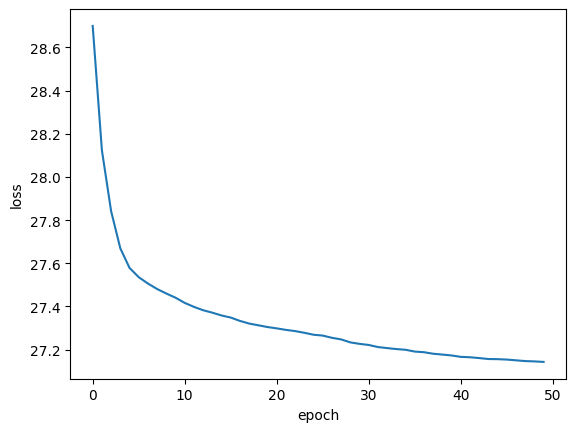

In [14]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = keras.utils.normalize(feature_vectors)


I0000 00:00:1748600128.484691    1776 service.cc:152] XLA service 0x7f69a4c303c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748600128.484726    1776 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-30 11:15:28.529490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-30 11:15:29.551994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483', 4 bytes spill stores, 4 bytes spill loads

2025-05-30 11:15:29.559885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483', 3312 bytes spill stores, 3016 bytes spill loads

2025-05-30 11:15:29.595081: I ext

 13/120 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

I0000 00:00:1748600132.928119    1776 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


In [16]:
knns = compute_knn(feature_vectors, batch_size=batch_size, kn=kn)


100%|██████████| 120/120 [00:04<00:00, 25.38it/s]


In [ ]:
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

clustering_model = create_clustering_model(encoder, num_clusters, input_shape, name='clustering')
clustering_learner = create_clustering_learner(clustering_model, input_shape)

losses = [ClustersEntropyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

inputs = {"anchor": x_data, 'neighbours': tf.gather(x_data, knns)}
labels = [np.ones(shape=(x_data.shape[0], kn)), np.ones(shape=(x_data.shape[0], kn))]

clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

clustering_learner.fit(
    x=inputs,
    y=labels,
    batch_size=512,
    epochs=50
)



Epoch 1/50


2025-05-30 11:15:59.550246: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/118 ━━━━━━━━━━━━━━━━━━━━ 15:38 8s/step - clustering_loss: 0.0860 - loss: 0.9303 - simlarity_loss: 0.8444

2025-05-30 11:15:59.837096: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 11:15:59.895810: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 56/118 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - clustering_loss: 0.1272 - loss: 0.6447 - simlarity_loss: 0.5175

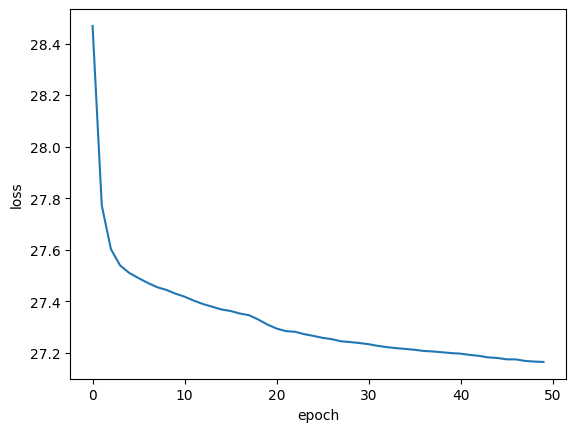

In [15]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [16]:
clustering_probabilitiys = clustering_model.predict(x_data, batch_size=batch_size)
cluster_assigment = keras.ops.argmax(clustering_probabilitiys, axis=-1).numpy()

cluster_confidence = keras.ops.max(clustering_probabilitiys, axis=-1).numpy()

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [17]:
from collections import defaultdict

clusters = defaultdict(list)

for idx, c in enumerate(cluster_assigment):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)

for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print(f"Cluster {c}:  {len(clusters[c])}")

Cluster 0:  1488
Cluster 1:  1308
Cluster 2:  1889
Cluster 3:  1854
Cluster 4:  1234
Cluster 5:  1885
Cluster 6:  2097
Cluster 7:  1604
Cluster 8:  2051
Cluster 9:  2144
Cluster 10:  1499
Cluster 11:  1520
Cluster 12:  1299
Cluster 13:  1674
Cluster 14:  1299
Cluster 15:  1962
Cluster 16:  8275
Cluster 17:  1851
Cluster 18:  1806
Cluster 19:  1451
Cluster 20:  1832
Cluster 21:  1371
Cluster 22:  1771
Cluster 23:  8962
Cluster 24:  1626
Cluster 25:  2003
Cluster 26:  767
Cluster 27:  1478


In [18]:
from sklearn.neighbors import NearestNeighbors

k = 5
cluster_knns = {}

for c, members in non_empty_clusters.items():
    indices = [idx for idx, _ in members]
    if len(indices) < k + 1:

        continue

    clutser_features = feature_vectors[indices]
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(clutser_features)

    distances, n_indices = nbrs.kneighbors(clutser_features)

    knns = [ [indices[n] for n in n[1:]] for n in n_indices]

    cluster_knns[c] = dict(zip(indices, knns))



In [19]:
type(cluster_knns)

dict

In [20]:
cluster_knns

{15: {0: [55810, 46049, 10924, 41928, 4201],
  66: [44578, 56098, 4668, 17733, 6178],
  98: [13361, 29218, 10985, 1396, 52441],
  113: [11761, 46047, 10687, 20713, 9076],
  163: [56940, 8557, 7320, 50437, 48447],
  186: [35017, 20272, 45606, 58041, 50717],
  187: [58475, 53203, 48454, 16478, 59406],
  228: [36790, 15614, 19900, 50395, 17676],
  270: [21196, 49369, 48236, 54105, 13193],
  293: [34094, 48248, 28003, 53528, 2427],
  307: [43835, 11371, 26771, 57602, 15159],
  314: [35994, 18241, 9185, 13439, 54285],
  327: [36552, 33272, 52925, 33210, 59821],
  411: [43662, 33081, 50630, 41375, 44901],
  439: [40287, 46504, 54063, 27982, 44691],
  471: [30099, 9549, 33139, 50771, 24520],
  489: [52222, 27611, 7232, 36348, 19511],
  525: [31884, 33272, 42099, 59821, 19940],
  530: [19903, 35250, 55502, 41690, 50779],
  575: [34283, 43163, 22327, 20135, 6872],
  588: [9797, 11917, 9978, 24728, 56801],
  642: [57690, 27914, 59789, 26990, 38763],
  692: [11582, 4651, 54637, 23460, 1630],
  70

In [21]:
feature_vectors

array([[ 0.05101068,  0.01604861, -0.02607972, ..., -0.0427454 ,
         0.05271827, -0.06031831],
       [ 0.05073831,  0.01620642, -0.02586159, ..., -0.04283962,
         0.05287831, -0.06032664],
       [ 0.05054338,  0.01633549, -0.02580543, ..., -0.04287898,
         0.05295099, -0.06025468],
       ...,
       [ 0.05115672,  0.01584207, -0.02608754, ..., -0.04262145,
         0.0526861 , -0.06037821],
       [ 0.05071655,  0.01621751, -0.02591114, ..., -0.04287026,
         0.05284813, -0.06034157],
       [ 0.05064052,  0.01620215, -0.02583156, ..., -0.04290802,
         0.05291994, -0.06030022]], dtype=float32)

In [22]:
feature_vectors = keras.utils.normalize(feature_vectors)


In [23]:
edge_list = []
for cluister in cluster_knns.values():
    for node, neighbors in cluster_knns.items():
        for neighbor in neighbors:
            edge_list.append([node, neighbor])

edge_list = np.array(edge_list)
edge_list = tf.cast(edge_list, dtype=tf.int32)

In [24]:
edge_list

<tf.Tensor: shape=(1680000, 2), dtype=int32, numpy=
array([[   15,     0],
       [   15,    66],
       [   15,    98],
       ...,
       [    1, 59838],
       [    1, 59892],
       [    1, 59961]], dtype=int32)>

In [25]:
feature_vectors

array([[ 0.05101069,  0.01604862, -0.02607972, ..., -0.0427454 ,
         0.05271828, -0.06031831],
       [ 0.05073831,  0.01620642, -0.02586159, ..., -0.04283962,
         0.05287831, -0.06032664],
       [ 0.05054338,  0.01633549, -0.02580543, ..., -0.04287898,
         0.05295099, -0.06025468],
       ...,
       [ 0.05115672,  0.01584207, -0.02608754, ..., -0.04262145,
         0.0526861 , -0.06037821],
       [ 0.05071655,  0.01621751, -0.02591114, ..., -0.04287026,
         0.05284813, -0.06034157],
       [ 0.05064052,  0.01620216, -0.02583156, ..., -0.04290802,
         0.05291994, -0.06030022]], dtype=float32)

In [26]:
hidden_units = 128
num_heads = 8
num_layers = 3
output_dim = 10

num_epochs = 100
batch_size = 256
validation_split = 0.1
learning_rate = 3e-1
momentum = 0.9

In [27]:
type(y_data)

numpy.ndarray

In [28]:
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(learning_rate, momentum=momentum)
accuracy = keras.metrics.CategoricalAccuracy()
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    restore_best_weights=True
)


In [29]:
edge_list.shape

TensorShape([1680000, 2])

In [30]:
feature_vectors = tf.convert_to_tensor(feature_vectors, dtype=tf.float32)
edge_list = tf.convert_to_tensor(edge_list, dtype=tf.int32)

In [31]:
model = GraphAttentionNetwork(
    node_states=feature_vectors,
    edges=edge_list,
    hidden_units=hidden_units,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim,
)

In [32]:
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=[accuracy],
)

In [33]:
train_indices = np.arange(len(y_data))
train_labels = y_data.flatten().astype(np.int32)

In [34]:
train_labels.shape

(60000,)

In [35]:
type(train_indices)

numpy.ndarray

In [36]:
train_indices.shape

(60000,)

In [37]:
train_labels = keras.utils.to_categorical(train_labels, num_classes=num_classes)

In [38]:
train_labels.shape

(60000, 10)

In [39]:
train_indices.shape

(60000,)

In [40]:
train_indices = np.array(train_indices)
train_labels = np.array(train_labels)

In [41]:
train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)

In [42]:
train_indices.shape

TensorShape([60000])

In [43]:
model.summary()

Model: "graph_attention_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention      │ ?                      │   0 (unbuilt) │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_1    │ ?                      │   0 (unbuilt) │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_2    │ ?                      │   0 (unbuilt) │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.fit(
    x=train_indices,
    y=train_labels,
    batch_size=32,
    epochs=num_epochs,
    callbacks=[early_stopping],
    verbose=2,
)